## 2024 Reinforcement Learning @ KHU

DQN
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/DQN
!ls
import sys; sys.path.append('..') # add project root to the python path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/RL/DQN
Double_DQN.ipynb  double_dqn.pt  DQN.ipynb  dqn.pt  Duel_DQN.ipynb  duel_dqn.pt


Car Racing

https://gymnasium.farama.org/environments/box2d/car_racing/


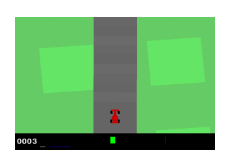

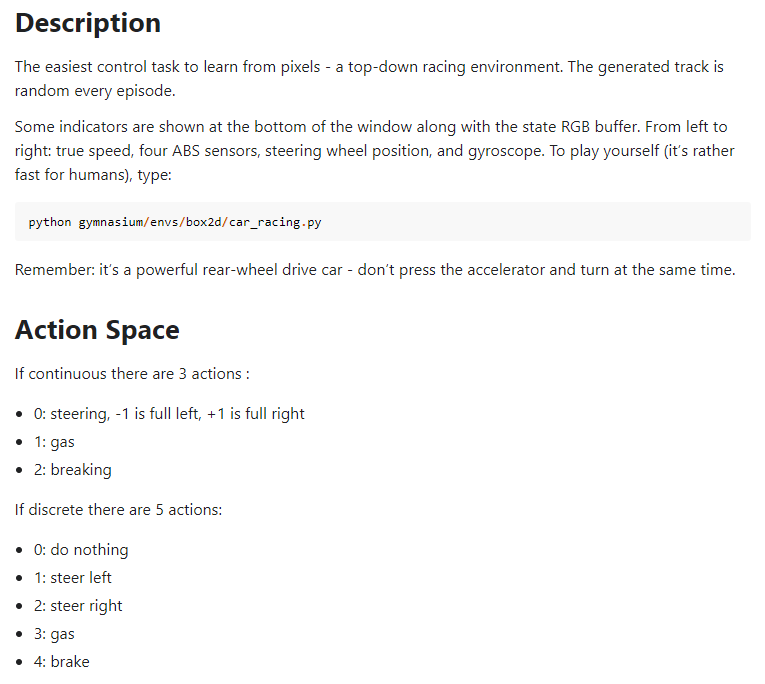

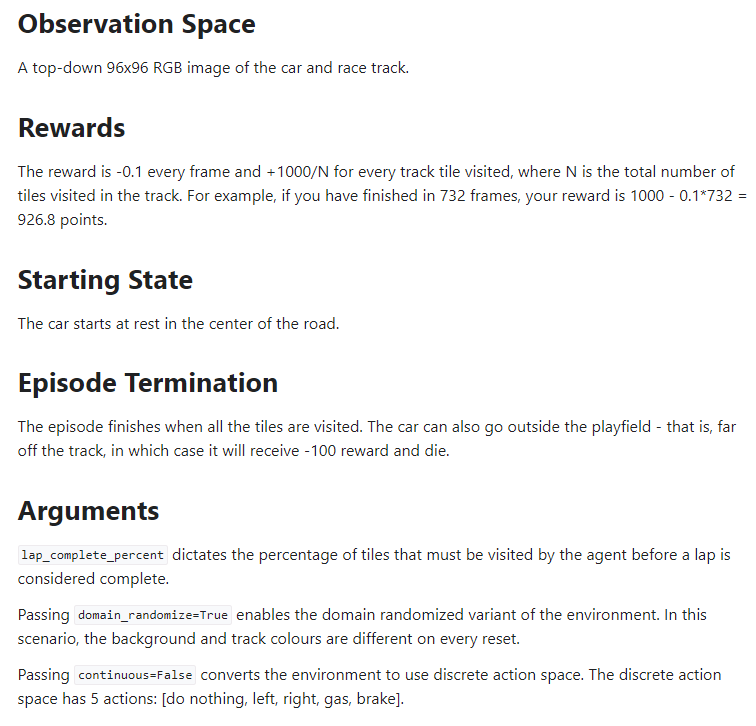

In [ ]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376105 sha256=e20feb838f43aca7759691fe1203d9b88c4bd9655ed10bc989fb45e3dc135858
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


## Check the Video

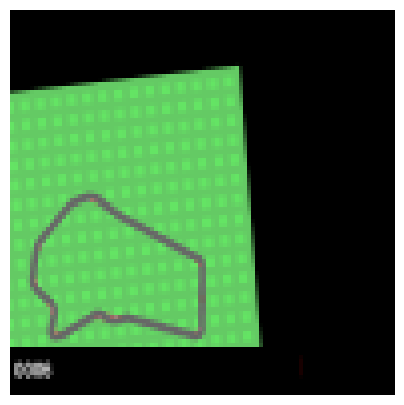

In [ ]:
env.reset()
frames = []
# 50 frame은 도입부라서 학습에 사용되지 않음 > PASS
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

# Preprocess the Image

In [ ]:
# Every frme always contains a black area at the bottom of the frame, so we had better cut this black area.
# Also, Color imformation is not directly related to car racing. So we will use gray image for computation efficiency.
# 학습에 불필요한 부분은 CROP 후에 사용함 (Grayscale로 변환)
def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

# Manual Environment

In [ ]:
class ImageEnv(gym.Wrapper):

# skip_frame: 한번 action을 수행하면 4frame동안 진행함
# stack_frame: 4프레임을 모아서 한번의 입력으로 제공함
# initial_no_op: 최초 skip 프레임 수

    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    # 처음으로 돌아감

    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        # terminated: 완료 / truncated: 실패
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

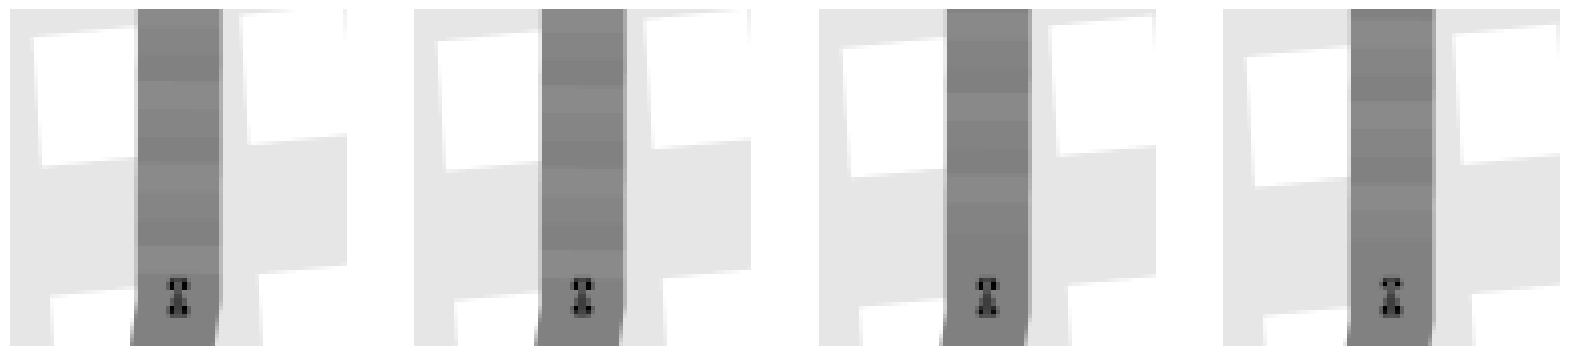

In [ ]:
"""
0: do nothing
1: steer left
2: steer right
3: steer gas
4: brake
"""
# 하나의 action이 4개의 frame에 적용되는 예시

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

env.reset()
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # #3 action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Network

### ouput tensor size of Convolution layer

- $O$ : Size(width) of output image
- $I$: Size(width) of input image
- $K$: Size(width) of kernels used in the Conv layer
- $N$: Number of kernels
- $S$: Stride of the convolution operation
- $P$: Padding size

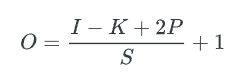

In [ ]:
class Net(nn.Module):

  def __init__(self,state_dim,action_dim):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(state_dim,16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
    self.in_features=32*9*9
    self.fc1=nn.Linear(self.in_features,256)
    self.fc2=nn.Linear(256,action_dim)


  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = x.view((-1, self.in_features))
      x = self.fc1(x)
      x = self.fc2(x)
      return x

# Replay Buffer

In [ ]:
class ReplayBuffer:

  def __init__(self,state_dim,action_dim,max_size=int(1e5)):
    self.s=np.zeros((max_size,*state_dim),dtype=np.float32)
    self.a=np.zeros((max_size,*action_dim),dtype=np.int64)
    self.r=np.zeros((max_size,1),dtype=np.float32)
    self.ns=np.zeros((max_size,*state_dim),dtype=np.float32)
    self.done=np.zeros((max_size,1),dtype=np.float32)


    self.ptr=0
    self.size=0
    self.max_size=max_size

  def update(self, s, a, r, ns, done):
      self.s[self.ptr] = s
      self.a[self.ptr] = a
      self.r[self.ptr] = r
      self.ns[self.ptr] = ns
      self.done[self.ptr] = done

      self.ptr = (self.ptr + 1) % self.max_size
      self.size = min(self.size + 1, self.max_size)

  def sample(self, batch_size):
      ind = np.random.randint(0, self.size, batch_size)
      return (
          torch.FloatTensor(self.s[ind]),
          torch.FloatTensor(self.a[ind]),
          torch.FloatTensor(self.r[ind]),
          torch.FloatTensor(self.ns[ind]),
          torch.FloatTensor(self.done[ind]),
      )

# DQN

[V. Mnih et al., "Human-level control through deep reinforcement learning." Nature, 518
(7540):529–533, 2015.](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as $Q$) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to $Q$ may significantly change the policy and therefore change the data distribution, and the correlations between the action-values ($Q$) and the target values $r + \gamma \max_{a'} Q(s', a')$.

The authors suggest two key ideas to address these instabilities with a novel variant of Q-learning: Replay buffer and Fixed Q-target.

### Uniformly random sampling from Experience Replay Memory

Reinforcement learning agent stores the experiences consecutively in the buffer, so adjacent ($s, a, r, s'$) transitions stored are highly likely to have correlation. To remove this, the agent samples experiences uniformly at random from the pool of stored samples $\big( (s, a, r, s') \sim U(D) \big)$. See sample_batch method of ReplayBuffer class for more details.

### Fixed Q-target

DQN uses an iterative update that adjusts the action-values ($Q$) towards target values that are only periodically updated, thereby reducing correlations with the target; if not, it is easily divergy because the target continuously moves. The Q-learning update at iteration $i$ uses the following loss function:

$$
L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)} \big[ \big( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s, a; \theta_i) \big)^2 \big]
$$

in which $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the Q-network at iteration $i$ and $\theta_i^-$ are the network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^-$ are only updated with the Q-network parameters ($\theta_i$) every C steps and are held fixed between individual updates.



In [ ]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e5),
        target_update_interval=10000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.Q = Net(state_dim[0], action_dim)
        self.target_Q = Net(state_dim[0], action_dim)
        self.target_Q.load_state_dict(self.Q.state_dict())
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.Q.to(self.device)
        self.target_Q.to(self.device)

        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6


    def select_action(self, x, training=True):

        # Exploration case
        # 1. Epsilon Greedy
        # 2. training (If evaluation, Just Greedy)
        # 3. warmup-steps
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.Q(x)
            a = torch.argmax(q,dim=1,keepdim=True).item()
        return a


    def update_model(self):

        s, a, r, ns, done = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))

        next_q=self.target_Q(ns).detach()

        td_target=r+(1.-done)*self.gamma*next_q.max(dim=-1,keepdim=True).values

        td_error=F.mse_loss(self.Q(s).gather(1,a.long()),td_target)
        self.optimizer.zero_grad()
        td_error.backward()
        self.optimizer.step()

    def process(self, transition):

        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            self.update_model()

        if self.total_steps % self.target_update_interval == 0:
            self.target_Q.load_state_dict(self.Q.state_dict())
        self.epsilon -= self.epsilon_decay

# Training

In [ ]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(1e6)
eval_interval = 10000
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DQN(state_dim, action_dim)

In [ ]:
def evaluate(n_evals=1):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)

    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.select_action(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

Training!!

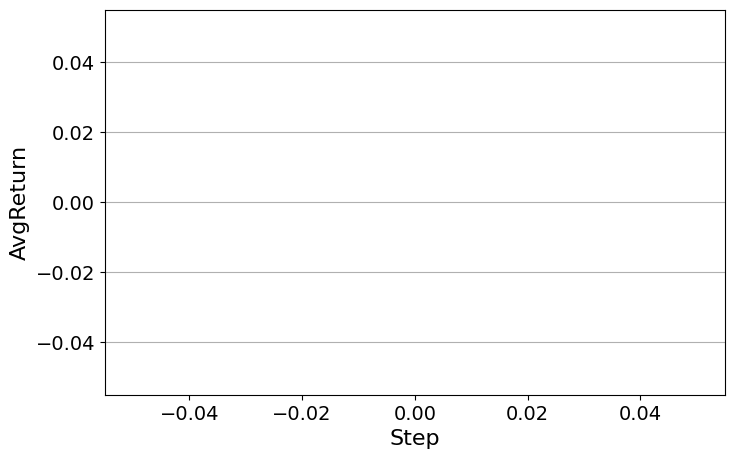

In [ ]:
history = {'Step': [], 'AvgReturn': []}
(s,_)=env.reset()
while True:
  a=agent.select_action(s)
  ns, r, done, truncated, info = env.step(a)
  # Update
  agent.process((s, a, r, ns, done))

  s=ns

  if done or truncated:
    (s,_)=env.reset()

  if agent.total_steps % eval_interval == 0:
    rewards = evaluate()
    history['Step'].append(agent.total_steps)
    history['AvgReturn'].append(rewards)

    clear_output()
    plt.figure(figsize=(8, 5))
    plt.plot(history['Step'], history['AvgReturn'], 'r-')
    plt.xlabel('Step', fontsize=16)
    plt.ylabel('AvgReturn', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y')
    plt.show()

    torch.save(agent.Q.state_dict(), 'dqn.pt')


  if agent.total_steps > max_steps:
    break

# Visualize

In [ ]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim)
agent.Q.load_state_dict(torch.load("dqn.pt"))

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.select_action(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

In [ ]:
# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.